In [1]:
!pip install pytrec_eval

  Preparing metadata (setup.py) ... done
  Created wheel for pytrec_eval: filename=pytrec_eval-0.5-cp310-cp310-linux_x86_64.whl size=308214 sha256=f1bfd7cc7faa445b7c97ee0331ae28de2c5b69c094cf623422bc9831aaf4b417
  Stored in directory: /root/.cache/pip/wheels/51/3a/cd/dcc1ddfc763987d5cb237165d8ac249aa98a23ab90f67317a8
Successfully built pytrec_eval


In [2]:
import nltk
from nltk.corpus import reuters, brown, wordnet
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity as cs
import matplotlib.pyplot as plt
import copy
import pytrec_eval
import json
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from scipy.sparse import csr_matrix
from collections import defaultdict

nltk.download('brown')
nltk.download('reuters')
nltk.download('inaugural')
nltk.download('punkt')

from google.colab import drive


[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Unzipping corpora/inaugural.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Corpus


In [3]:
def corpus_data(corpus):
    if corpus == "reuters_corpus":
        reuters_corpus = reuters.sents(categories=['crude', 'money-fx'])
        text_data = [" ".join(i) for i in reuters_corpus]
        return text_data, reuters_corpus
    else:
        brown_corpus = brown.sents(categories=['news', 'editorial'])
        text_data = [" ".join(i) for i in brown_corpus]
        return text_data, brown_corpus


In [4]:
# C, _ = corpus_data("reuters_corpus")
# C[:10]

['JAPAN TO REVISE LONG - TERM ENERGY DEMAND DOWNWARDS The Ministry of International Trade and Industry ( MITI ) will revise its long - term energy supply / demand outlook by August to meet a forecast downtrend in Japanese energy demand , ministry officials said .',
 'MITI is expected to lower the projection for primary energy supplies in the year 2000 to 550 mln kilolitres ( kl ) from 600 mln , they said .',
 'The decision follows the emergence of structural changes in Japanese industry following the rise in the value of the yen and a decline in domestic electric power demand .',
 'MITI is planning to work out a revised energy supply / demand outlook through deliberations of committee meetings of the Agency of Natural Resources and Energy , the officials said .',
 'They said MITI will also review the breakdown of energy supply sources , including oil , nuclear , coal and natural gas .',
 "Nuclear energy provided the bulk of Japan ' s electric power in the fiscal year ended March 31 , s

In [ ]:
# C, _ = corpus_data("brown")
# C[:10]

['Fellow - Citizens of the Senate and of the House of Representatives :',
 'Among the vicissitudes incident to life no event could have filled me with greater anxieties than that of which the notification was transmitted by your order , and received on the 14th day of the present month .',
 'On the one hand , I was summoned by my Country , whose voice I can never hear but with veneration and love , from a retreat which I had chosen with the fondest predilection , and , in my flattering hopes , with an immutable decision , as the asylum of my declining years -- a retreat which was rendered every day more necessary as well as more dear to me by the addition of habit to inclination , and of frequent interruptions in my health to the gradual waste committed on it by time .',
 'On the other hand , the magnitude and difficulty of the trust to which the voice of my country called me , being sufficient to awaken in the wisest and most experienced of her citizens a distrustful scrutiny into his

### Golden	standard

In [5]:
simlex_file_path = "/content/SimLex-999.txt"

word_pairs = []
similarities = []

with open(simlex_file_path, 'r', encoding='utf-8') as g:
    next(g)
    for line in g:
        fields = line.strip().split('\t')
        word_pairs.append((fields[0].lower(), fields[1].lower()))
        similarities.append(float(fields[3]))

word1, word2 = zip(*word_pairs)
similarity = np.asarray(similarities)

### top-k

In [25]:
def top_k_similar_words(word1, word2, list_sim, vocab):
    topk = defaultdict(list)
    for i in range(len(word1)):
        if word1[i] in vocab:
            topk[word1[i]].append([list_sim[i], word2[i]])
        if word2[i] in vocab:
            topk[word2[i]].append([list_sim[i], word1[i]])
    return dict(topk)

In [7]:
def count_invalid_top_k_words(topk):
    invalid_count = 0
    for word, similar_words in topk.items():
        if len(similar_words) != 10:
            invalid_count += 1
    return invalid_count

In [26]:
def get_added_words(similarity, word2, word1_list, word2_list, top_words, word, sim_list):
    added_words = []
    if word2 in word1_list:
        indices = [i for i, x in enumerate(word1_list) if x == word2]
        for ind in indices:
            if word2_list[ind] not in top_words[:, 1] and word2_list[ind] != word and word2_list[ind] not in added_words:
                added_words.append([sim_list[ind]*(similarity/max(sim_list)), word2_list[ind]])
    if word2 in word2_list:
        indices = [i for i, x in enumerate(word2_list) if x == word2]
        for ind in indices:
            if word1_list[ind] not in top_words[:, 1] and word1_list[ind] != word and word1_list[ind] not in added_words:
                added_words.append([sim_list[ind]*(similarity/max(sim_list)), word1_list[ind]])
    return added_words

def add_to_topk(topk, addedWords, addCounter, word):
    addedWords = sorted(addedWords, reverse=True)
    while len(topk[word]) < 10 and addCounter < len(addedWords):
        topk[word].append(addedWords[addCounter])
        addCounter += 1
    return topk

def extend_topk(topk, word1_list, word2_list, sim_list, vocab):
    for word in topk.keys():
        if len(topk[word]) >= 10:
            topk[word] = sorted(topk[word], reverse=True)[:10]
        else:
            topk[word] = sorted(topk[word], reverse=True)
            top_words = np.asarray(topk[word])
            addedWords = []
            for similarity, word2 in topk[word]:
                addedWords += get_added_words(similarity, word2, word1_list, word2_list, top_words, word, sim_list)
            addCounter = 0
            topk = add_to_topk(topk, addedWords, addCounter, word)
    return topk

In [28]:
def transitivity_rule(topk, word1, word2, similarity, vocab, render=True):
    invalid_counts = []
    invalid_counts.append(count_invalid_top_k_words(topk))
    while True:
        updated_topk = extend_topk(topk, word1, word2, similarity, vocab)
        invalid_count = count_invalid_top_k_words(updated_topk)
        invalid_counts.append(invalid_count)
        if invalid_count == invalid_counts[-2]:
            break
        topk = updated_topk

    if render:
        plt.bar(range(len(invalid_counts)), invalid_counts, align='center')
        plt.xlabel('# Transitive Operations')
        plt.ylabel('# Similar Words != 10')
        plt.title('Required Transitive Operations')
        plt.show()

    return topk

### Tf-idf

In [11]:
def generate_dictionary(model_dict, ground_truth):
    model_dictionary = {}
    for key, values in model_dict.items():
        model_dictionary[key] = {value: 1 for value in values}

    ground_truth_dictionary = {}
    for key, values in ground_truth.items():
        ground_truth_dictionary[key] = {value[1]: 1 for value in values}

    return model_dictionary, ground_truth_dictionary

def search_top_similar_words(ground_truth, similarities, vocab):
    top_similar_words = {}

    vocab_array = np.asarray(vocab)

    for key in ground_truth.keys():
        key_index = None
        if key in vocab_array:
            key_index = np.where(vocab_array == key)[0][0]

        if key_index is not None:
            similarity_vector = similarities[key_index].toarray().flatten()  # Convert to dense array
            sorted_indices = np.flip(np.argsort(similarity_vector)[-11:])  # Use argsort on dense array
            sorted_indices = np.setdiff1d(sorted_indices, key_index)
            similar_words = vocab_array[sorted_indices]
            top_similar_words[key] = similar_words

    return top_similar_words


### Word 2 vec

In [12]:
def generate_word2vec_data(model, ground_truth):
    word_vector_dict = {}
    for word in model.wv.index_to_key:
        vectors = model.wv.most_similar(word, topn=10)
        word_vector_dict[word] = {v[0]: 1 for v in vectors}

    ground_truth_dict = {}
    for word, similar_words in ground_truth.items():
        ground_truth_dict[word] = {sw[1]: 1 for sw in similar_words}

    return word_vector_dict, ground_truth_dict




### Reuters

In [29]:
def mean_ndcg(evaluation_results):
    ndcg_scores = [result['ndcg'] for result in evaluation_results.values()]
    return sum(ndcg_scores) / len(ndcg_scores)

def median_ndcg(evaluation_results):
    ndcg_scores = [result['ndcg'] for result in evaluation_results.values()]
    return np.median(ndcg_scores)

def top_k_ndcg(evaluation_results, k=10):
    ndcg_scores = [result['ndcg'] for result in evaluation_results.values()]
    top_k_scores = ndcg_scores[:k]
    return sum(top_k_scores) / len(top_k_scores)

def interquartile_range(evaluation_results):
    ndcg_scores = [result['ndcg'] for result in evaluation_results.values()]
    return np.percentile(ndcg_scores, 75) - np.percentile(ndcg_scores, 25)
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
C, _ = corpus_data("reuters_corpus")
tfidf_matrix = tfidf_vectorizer.fit_transform(C)
tfidf_dataframe = pd.DataFrame(tfidf_matrix.T.todense())
tfidf_similarities = csr_matrix(cs(tfidf_dataframe))
tfidf_vocab = list(tfidf_vectorizer.vocabulary_.keys())
top_similar_words = top_k_similar_words(word1, word2, similarity, tfidf_vocab)
transitive_similar_words = transitivity_rule(deepcopy(top_similar_words), word1, word2, similarity, tfidf_vocab, render=False)
model_tops = search_top_similar_words(transitive_similar_words, tfidf_similarities, tfidf_vocab)
query_dict, run_dict = generate_dictionary(model_tops, transitive_similar_words)
evaluator = pytrec_eval.RelevanceEvaluator(query_dict, {'ndcg'})
evaluation_results = evaluator.evaluate(run_dict)
mean_ndcg_score = mean_ndcg(evaluation_results)
median_ndcg_score = median_ndcg(evaluation_results)
top_k_ndcg_score = top_k_ndcg(evaluation_results, k=10)
interquartile_range_score = interquartile_range(evaluation_results)

print(f"Mean NDCG: {mean_ndcg_score}")
print(f"Median NDCG: {median_ndcg_score}")
print(f"Top-10 NDCG: {top_k_ndcg_score}")
print(f"Interquartile Range of NDCG: {interquartile_range_score}")

Mean NDCG: 0.00039854669011677953
Median NDCG: 0.0
Top-10 NDCG: 0.0
Interquartile Range of NDCG: 0.0


In [33]:
df_results = pd.DataFrame(evaluation_results).T.reset_index()
df_results.columns = ['Query', 'NDCG']
df_results_sorted = df_results.sort_values(by='NDCG', ascending=False)
df_results_sorted.head()

,Query,NDCG
449,choose,0.078398
34,big,0.073364
42,flexible,0.069431
0,old,0.000000
373,denial,0.000000


In [34]:
df_results['NDCG'].unique()

array([0.        , 0.07336392, 0.06943122, 0.07839827])

In [ ]:
# import statistics
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# results = []

# # Define parameters
# window_sizes = [1, 2, 5, 10]
# vector_sizes = [10, 50, 100, 300]
# iterations = 1000

# # Load data
# _, reut_ds = corpus_data('reuters_corpus')

# # Iterate over window sizes and vector sizes
# for window_size in window_sizes:
#     for vector_size in vector_sizes:
#         # Train Word2Vec model
#         model = Word2Vec(sentences=reut_ds, vector_size=vector_size, window=window_size, epochs=iterations)

#         # Specify the directory in Google Drive to save the model
#         save_path = f'/content/drive/My Drive/Word2Vec_Models/model_ws{window_size}_vs{vector_size}.model'

#         # Save the trained model to Google Drive
#         model.save(save_path)

#         # Extract vocabulary
#         vocabulary = list(model.wv.index_to_key)

#         # Get top similar words
#         similar_words = top_k_similar_words(word1, word2, similarity, vocabulary)

#         # Evaluate using Word2Vec
#         method = 'Word2Vec'
#         word_vector_dict, ground_truth_dict = generate_word2vec_data(model, similar_words)
#         evaluator = pytrec_eval.RelevanceEvaluator(word_vector_dict, {'ndcg'})
#         evaluation_results = evaluator.evaluate(ground_truth_dict)

#         # Compute mean NDCG
#         ndcg_scores = [result['ndcg'] for result in evaluation_results.values()]
#         mean_ndcg = statistics.mean(ndcg_scores)

#         # Compute additional metrics
#         median_ndcg = statistics.median(ndcg_scores)
#         top10_ndcg = statistics.mean(ndcg_scores[:10]) if len(ndcg_scores) >= 10 else 0
#         interquartile_range_ndcg = statistics.quantiles(ndcg_scores, n=4)[-1] - statistics.quantiles(ndcg_scores, n=4)[0]

#         # Print results
#         print(f'Mean NDCG: window_size={window_size}, vector_size={vector_size}: {mean_ndcg}')
#         print(f'Median NDCG: window_size={window_size}, vector_size={vector_size}: {median_ndcg}')
#         print(f'Top-10 NDCG: window_size={window_size}, vector_size={vector_size}: {top10_ndcg}')
#         print(f'Interquartile Range of NDCG: window_size={window_size}, vector_size={vector_size}: {interquartile_range_ndcg}')


Mounted at /content/drive
Mean NDCG: window_size=1, vector_size=10: 0.0037638402624313866
Median NDCG: window_size=1, vector_size=10: 0.0
Top-10 NDCG: window_size=1, vector_size=10: 0.023365080824310533
Interquartile Range of NDCG: window_size=1, vector_size=10: 0.0
Mean NDCG: window_size=1, vector_size=50: 0.00944364239221459
Median NDCG: window_size=1, vector_size=50: 0.0
Top-10 NDCG: window_size=1, vector_size=50: 0.022009176629808017
Interquartile Range of NDCG: window_size=1, vector_size=50: 0.0
Mean NDCG: window_size=1, vector_size=100: 0.01537526027135537
Median NDCG: window_size=1, vector_size=100: 0.0
Top-10 NDCG: window_size=1, vector_size=100: 0.04401835325961603
Interquartile Range of NDCG: window_size=1, vector_size=100: 0.0
Mean NDCG: window_size=1, vector_size=300: 0.011368001733817867
Median NDCG: window_size=1, vector_size=300: 0.0
Top-10 NDCG: window_size=1, vector_size=300: 0.0
Interquartile Range of NDCG: window_size=1, vector_size=300: 0.0
Mean NDCG: window_size=2,

In [35]:
drive.mount('/content/drive')

# Define parameters
window_sizes = [1, 2, 5, 10]
vector_sizes = [10, 50, 100, 300]
iterations = 1000

# Load data
_, reut_ds = corpus_data('reuters_corpus')

# Iterate over window sizes and vector sizes
for window_size in window_sizes:
    for vector_size in vector_sizes:
        # Load Word2Vec model from the saved path
        save_path = f'/content/drive/My Drive/Word2Vec_Models/model_ws{window_size}_vs{vector_size}.model'
        model = Word2Vec.load(save_path)

        # Extract vocabulary
        vocabulary = list(model.wv.index_to_key)

        # Get top similar words
        similar_words = top_k_similar_words(word1, word2, similarity, vocabulary)

        # Evaluate using Word2Vec
        method = 'Word2Vec'
        word_vector_dict, ground_truth_dict = generate_word2vec_data(model, similar_words)
        evaluator = pytrec_eval.RelevanceEvaluator(word_vector_dict, {'ndcg'})
        evaluation_results = evaluator.evaluate(ground_truth_dict)

        # Compute mean NDCG
        ndcg_scores = [result['ndcg'] for result in evaluation_results.values()]
        mean_ndcg = statistics.mean(ndcg_scores)

        # Compute additional metrics
        median_ndcg = statistics.median(ndcg_scores)
        top10_ndcg = statistics.mean(ndcg_scores[:10]) if len(ndcg_scores) >= 10 else 0
        interquartile_range_ndcg = statistics.quantiles(ndcg_scores, n=4)[-1] - statistics.quantiles(ndcg_scores, n=4)[0]

        # Print results
        print(f'Mean NDCG: window_size={window_size}, vector_size={vector_size}: {mean_ndcg}')
        print(f'Median NDCG: window_size={window_size}, vector_size={vector_size}: {median_ndcg}')
        print(f'Top-10 NDCG: window_size={window_size}, vector_size={vector_size}: {top10_ndcg}')
        print(f'Interquartile Range of NDCG: window_size={window_size}, vector_size={vector_size}: {interquartile_range_ndcg}')


Mounted at /content/drive
Mean NDCG: window_size=1, vector_size=10: 0.0037638402624313866
Median NDCG: window_size=1, vector_size=10: 0.0
Top-10 NDCG: window_size=1, vector_size=10: 0.023365080824310533
Interquartile Range of NDCG: window_size=1, vector_size=10: 0.0
Mean NDCG: window_size=1, vector_size=50: 0.00944364239221459
Median NDCG: window_size=1, vector_size=50: 0.0
Top-10 NDCG: window_size=1, vector_size=50: 0.022009176629808017
Interquartile Range of NDCG: window_size=1, vector_size=50: 0.0
Mean NDCG: window_size=1, vector_size=100: 0.01537526027135537
Median NDCG: window_size=1, vector_size=100: 0.0
Top-10 NDCG: window_size=1, vector_size=100: 0.04401835325961603
Interquartile Range of NDCG: window_size=1, vector_size=100: 0.0
Mean NDCG: window_size=1, vector_size=300: 0.011368001733817867
Median NDCG: window_size=1, vector_size=300: 0.0
Top-10 NDCG: window_size=1, vector_size=300: 0.0
Interquartile Range of NDCG: window_size=1, vector_size=300: 0.0
Mean NDCG: window_size=2,

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


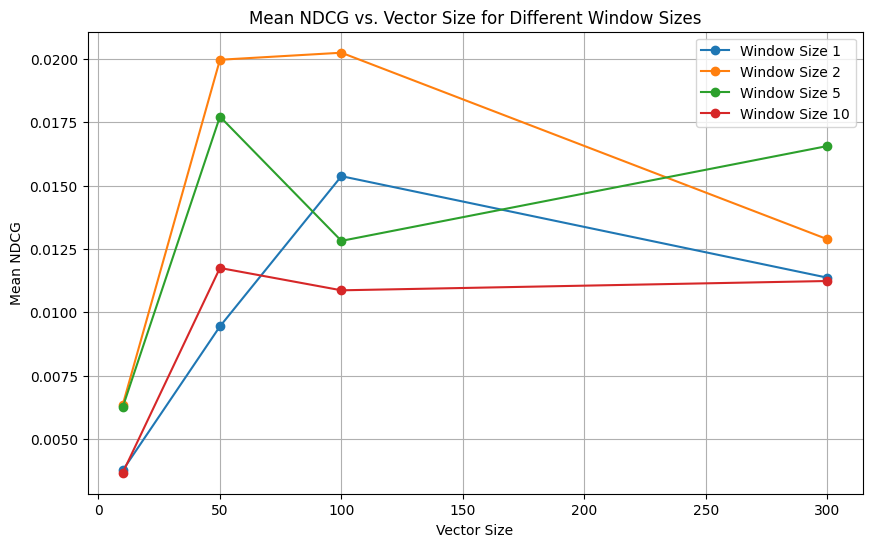

In [36]:
import statistics
import matplotlib.pyplot as plt
from google.colab import drive
from gensim.models import Word2Vec

# Mount Google Drive
drive.mount('/content/drive')

# Define parameters
window_sizes = [1, 2, 5, 10]
vector_sizes = [10, 50, 100, 300]
iterations = 1

# Lists to store mean NDCG values for each combination of window size and vector size
mean_ndcg_values = []

# Load data
_, reut_ds = corpus_data('reuters_corpus')

# Iterate over window sizes and vector sizes
for window_size in window_sizes:
    mean_ndcg_values_row = []
    for vector_size in vector_sizes:
        save_path = f'/content/drive/My Drive/Word2Vec_Models/model_ws{window_size}_vs{vector_size}.model'
        model = Word2Vec.load(save_path)

        vocabulary = list(model.wv.index_to_key)

        similar_words = top_k_similar_words(word1, word2, similarity, vocabulary)

        method = 'Word2Vec'
        word_vector_dict, ground_truth_dict = generate_word2vec_data(model, similar_words)
        evaluator = pytrec_eval.RelevanceEvaluator(word_vector_dict, {'ndcg'})
        evaluation_results = evaluator.evaluate(ground_truth_dict)

        ndcg_scores = [result['ndcg'] for result in evaluation_results.values()]
        mean_ndcg = statistics.mean(ndcg_scores)
        mean_ndcg_values_row.append(mean_ndcg)  # Append mean NDCG value to the temporary list

    mean_ndcg_values.append(mean_ndcg_values_row)  # Append the row of mean NDCG values to the main list

plt.figure(figsize=(10, 6))
for i, window_size in enumerate(window_sizes):
    plt.plot(vector_sizes, mean_ndcg_values[i], marker='o', label=f'Window Size {window_size}')

plt.title('Mean NDCG vs. Vector Size for Different Window Sizes')
plt.xlabel('Vector Size')
plt.ylabel('Mean NDCG')
plt.legend()
plt.grid(True)
plt.show()


### Brown

In [ ]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
C, _ = corpus_data("brown")
tfidf_matrix = tfidf_vectorizer.fit_transform(C)
tfidf_dataframe = pd.DataFrame(tfidf_matrix.T.todense())
tfidf_similarities = csr_matrix(cs(tfidf_dataframe))
tfidf_vocab = list(tfidf_vectorizer.vocabulary_.keys())
top_similar_words = top_k_similar_words(word1, word2, similarity, tfidf_vocab)
transitive_similar_words = transitivity_rule(deepcopy(top_similar_words), word1, word2, similarity, tfidf_vocab, render=False)
model_tops = search_top_similar_words(transitive_similar_words, tfidf_similarities, tfidf_vocab)
query_dict, run_dict = generate_dictionary(model_tops, transitive_similar_words)
evaluator = pytrec_eval.RelevanceEvaluator(query_dict, {'ndcg'})
evaluation_results = evaluator.evaluate(run_dict)
mean_ndcg_score = mean_ndcg(evaluation_results)
median_ndcg_score = median_ndcg(evaluation_results)
top_k_ndcg_score = top_k_ndcg(evaluation_results, k=10)
interquartile_range_score = interquartile_range(evaluation_results)

print(f"Mean NDCG: {mean_ndcg_score}")
print(f"Median NDCG: {median_ndcg_score}")
print(f"Top-10 NDCG: {top_k_ndcg_score}")
print(f"Interquartile Range of NDCG: {interquartile_range_score}")

Mean NDCG: 0.0007726914581041372
Median NDCG: 0.0
Top-10 NDCG: 0.006362078819895171
Interquartile Range of NDCG: 0.0


In [ ]:
df_results = pd.DataFrame(evaluation_results).T.reset_index()
df_results.columns = ['Query', 'NDCG']
df_results_sorted = df_results.sort_values(by='NDCG', ascending=False)
df_results_sorted.head()

,Query,NDCG
488,king,0.220092
174,hand,0.138862
449,helper,0.085143
123,instructor,0.078398
175,thumb,0.078398


In [ ]:
df_results['NDCG'].unique()

array([0.06362079, 0.        , 0.07839827, 0.13886244, 0.08514312,
       0.22009177])

In [ ]:
import statistics
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

results = []

# Define parameters
window_sizes = [1, 2, 5, 10]
vector_sizes = [10, 50, 100, 300]
iterations = 1000

# Load data
_, brown_ds = corpus_data('brown')


# Iterate over window sizes and vector sizes
for window_size in window_sizes:
    for vector_size in vector_sizes:
        # Train Word2Vec model
        model = Word2Vec(sentences=brown_ds, vector_size=vector_size, window=window_size, epochs=iterations)

        # Specify the directory in Google Drive to save the model
        save_path = f'/content/drive/My Drive/Word2Vec_Models/model_brown{window_size}_vs{vector_size}.model'

        # Save the trained model to Google Drive
        model.save(save_path)

        # Extract vocabulary
        vocabulary = list(model.wv.index_to_key)

        # Get top similar words
        similar_words = top_k_similar_words(word1, word2, similarity, vocabulary)

        # Evaluate using Word2Vec
        method = 'Word2Vec'
        word_vector_dict, ground_truth_dict = generate_word2vec_data(model, similar_words)
        evaluator = pytrec_eval.RelevanceEvaluator(word_vector_dict, {'ndcg'})
        evaluation_results = evaluator.evaluate(ground_truth_dict)

        # Compute mean NDCG
        ndcg_scores = [result['ndcg'] for result in evaluation_results.values()]
        mean_ndcg = statistics.mean(ndcg_scores)

        # Compute additional metrics
        median_ndcg = statistics.median(ndcg_scores)
        top10_ndcg = statistics.mean(ndcg_scores[:10]) if len(ndcg_scores) >= 10 else 0
        interquartile_range_ndcg = statistics.quantiles(ndcg_scores, n=4)[-1] - statistics.quantiles(ndcg_scores, n=4)[0]

        # Print results
        print(f'Mean NDCG: window_size={window_size}, vector_size={vector_size}: {mean_ndcg}')
        print(f'Median NDCG: window_size={window_size}, vector_size={vector_size}: {median_ndcg}')
        print(f'Top-10 NDCG: window_size={window_size}, vector_size={vector_size}: {top10_ndcg}')
        print(f'Interquartile Range of NDCG: window_size={window_size}, vector_size={vector_size}: {interquartile_range_ndcg}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mean NDCG: window_size=1, vector_size=10: 0.012285504208467529
Median NDCG: window_size=1, vector_size=10: 0.0
Top-10 NDCG: window_size=1, vector_size=10: 0.0
Interquartile Range of NDCG: window_size=1, vector_size=10: 0.0
Mean NDCG: window_size=1, vector_size=50: 0.005164273629919958
Median NDCG: window_size=1, vector_size=50: 0.0
Top-10 NDCG: window_size=1, vector_size=50: 0.0
Interquartile Range of NDCG: window_size=1, vector_size=50: 0.0
Mean NDCG: window_size=1, vector_size=100: 0.00335169677431716
Median NDCG: window_size=1, vector_size=100: 0.0
Top-10 NDCG: window_size=1, vector_size=100: 0.0
Interquartile Range of NDCG: window_size=1, vector_size=100: 0.0
Mean NDCG: window_size=1, vector_size=300: 0.0047165697472936014
Median NDCG: window_size=1, vector_size=300: 0.0
Top-10 NDCG: window_size=1, vector_size=300: 0.0
Interquartile Range of NDCG: window_

In [ ]:
import statistics
from google.colab import drive
from gensim.models import Word2Vec

# Mount Google Drive
drive.mount('/content/drive')

# Define parameters
window_sizes = [1, 2, 5, 10]
vector_sizes = [10, 50, 100, 300]

# Load data
# _, inaug_ds = corpus_data('inaugural')
_, brown_ds = corpus_data('brown')


# Iterate over window sizes and vector sizes
for window_size in window_sizes:
    for vector_size in vector_sizes:
        # Load Word2Vec model from the saved path
        save_path = f'/content/drive/My Drive/Word2Vec_Models/model_brown{window_size}_vs{vector_size}.model'
        model = Word2Vec.load(save_path)

        # Extract vocabulary
        vocabulary = list(model.wv.index_to_key)

        # Get top similar words
        similar_words = top_k_similar_words(word1, word2, similarity, vocabulary)

        # Evaluate using Word2Vec
        method = 'Word2Vec'
        word_vector_dict, ground_truth_dict = generate_word2vec_data(model, similar_words)
        evaluator = pytrec_eval.RelevanceEvaluator(word_vector_dict, {'ndcg'})
        evaluation_results = evaluator.evaluate(ground_truth_dict)

        # Compute mean NDCG
        ndcg_scores = [result['ndcg'] for result in evaluation_results.values()]
        mean_ndcg = statistics.mean(ndcg_scores)

        # Compute additional metrics
        median_ndcg = statistics.median(ndcg_scores)
        top10_ndcg = statistics.mean(ndcg_scores[:10]) if len(ndcg_scores) >= 10 else 0
        interquartile_range_ndcg = statistics.quantiles(ndcg_scores, n=4)[-1] - statistics.quantiles(ndcg_scores, n=4)[0]

        # Print results
        print(f'Mean NDCG: window_size={window_size}, vector_size={vector_size}: {mean_ndcg}')
        print(f'Median NDCG: window_size={window_size}, vector_size={vector_size}: {median_ndcg}')
        print(f'Top-10 NDCG: window_size={window_size}, vector_size={vector_size}: {top10_ndcg}')
        print(f'Interquartile Range of NDCG: window_size={window_size}, vector_size={vector_size}: {interquartile_range_ndcg}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mean NDCG: window_size=1, vector_size=10: 0.012285504208467529
Median NDCG: window_size=1, vector_size=10: 0.0
Top-10 NDCG: window_size=1, vector_size=10: 0.0
Interquartile Range of NDCG: window_size=1, vector_size=10: 0.0
Mean NDCG: window_size=1, vector_size=50: 0.005164273629919958
Median NDCG: window_size=1, vector_size=50: 0.0
Top-10 NDCG: window_size=1, vector_size=50: 0.0
Interquartile Range of NDCG: window_size=1, vector_size=50: 0.0
Mean NDCG: window_size=1, vector_size=100: 0.00335169677431716
Median NDCG: window_size=1, vector_size=100: 0.0
Top-10 NDCG: window_size=1, vector_size=100: 0.0
Interquartile Range of NDCG: window_size=1, vector_size=100: 0.0
Mean NDCG: window_size=1, vector_size=300: 0.0047165697472936014
Median NDCG: window_size=1, vector_size=300: 0.0
Top-10 NDCG: window_size=1, vector_size=300: 0.0
Interquartile Range of NDCG: window_

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


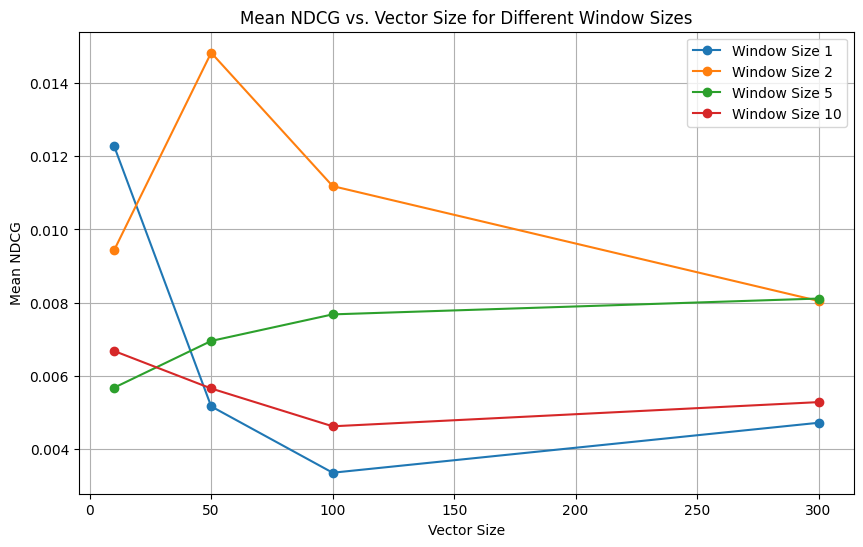

In [ ]:
import statistics
import matplotlib.pyplot as plt
from google.colab import drive
from gensim.models import Word2Vec

# Mount Google Drive
drive.mount('/content/drive')

# Define parameters
window_sizes = [1, 2, 5, 10]
vector_sizes = [10, 50, 100, 300]
iterations = 1

# Lists to store mean NDCG values for each combination of window size and vector size
mean_ndcg_values = []

# Load data
_, reut_ds = corpus_data('reuters_corpus')

# Iterate over window sizes and vector sizes
for window_size in window_sizes:
    mean_ndcg_values_row = []
    for vector_size in vector_sizes:
        save_path = f'/content/drive/My Drive/Word2Vec_Models/model_brown{window_size}_vs{vector_size}.model'
        model = Word2Vec.load(save_path)

        vocabulary = list(model.wv.index_to_key)

        similar_words = top_k_similar_words(word1, word2, similarity, vocabulary)

        method = 'Word2Vec'
        word_vector_dict, ground_truth_dict = generate_word2vec_data(model, similar_words)
        evaluator = pytrec_eval.RelevanceEvaluator(word_vector_dict, {'ndcg'})
        evaluation_results = evaluator.evaluate(ground_truth_dict)

        ndcg_scores = [result['ndcg'] for result in evaluation_results.values()]
        mean_ndcg = statistics.mean(ndcg_scores)
        mean_ndcg_values_row.append(mean_ndcg)  # Append mean NDCG value to the temporary list

    mean_ndcg_values.append(mean_ndcg_values_row)  # Append the row of mean NDCG values to the main list

plt.figure(figsize=(10, 6))
for i, window_size in enumerate(window_sizes):
    plt.plot(vector_sizes, mean_ndcg_values[i], marker='o', label=f'Window Size {window_size}')

plt.title('Mean NDCG vs. Vector Size for Different Window Sizes')
plt.xlabel('Vector Size')
plt.ylabel('Mean NDCG')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from gensim.models import Word2Vec
from nltk.corpus import wordnet
nltk.download('wordnet')

# Load the Word2Vec model

save_path = f'/content/drive/My Drive/Word2Vec_Models/model_brown{window_size}_vs{vector_size}.model'
model = Word2Vec.load(save_path)

# model = Word2Vec.load('path_to_your_word2vec_model')

def get_top_words(word, n=10):
    # Using Word2Vec for vector semantics
    similar_words_w2v = model.wv.most_similar(word, topn=n)

    # Using WordNet for lexical semantics
    synsets = wordnet.synsets(word)
    similar_words_wordnet = []
    for synset in synsets:
        for lemma in synset.lemmas():
            similar_words_wordnet.append(lemma.name())

    return similar_words_w2v, similar_words_wordnet

# Example usage
word = 'car'
similar_words_w2v, similar_words_wordnet = get_top_words(word)
print("Similar words using Word2Vec:")
print(similar_words_w2v)
print("\nSimilar words using WordNet:")
print(similar_words_wordnet)


[nltk_data] Downloading package wordnet to /root/nltk_data...


Similar words using Word2Vec:
[('hammock', 0.23427116870880127), ('accompanied', 0.2253161072731018), ('low', 0.22260083258152008), ('Podger', 0.21290463209152222), ('walking', 0.21084564924240112), ('market', 0.20063884556293488), ('Breeding', 0.18695183098316193), ('Avenue', 0.18665815889835358), ('colony', 0.18146371841430664), ('Providence', 0.18141670525074005)]

Similar words using WordNet:
['car', 'auto', 'automobile', 'machine', 'motorcar', 'car', 'railcar', 'railway_car', 'railroad_car', 'car', 'gondola', 'car', 'elevator_car', 'cable_car', 'car']
